Hunter Bennett | June 16 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
f1Dir = '/home/ttroutman/strainsKupffer/rnaKupfferF1/'
nsgDir = '/home/ttroutman/strainsKupffer/rnaKupfferNSG_20210201/'
workingDirectory = '/home/h1bennet/strains_manuscript/results/03_Strains_Manuscript_Compare_CB6F1_NSG//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

# Compare cis / trans / mixed lists...
How many trans regulated genes are shared between sets...

In [5]:
f1_dict = {}
for genelist in glob.glob('/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/gene_lists/*filt_pval.txt'):
    with open(genelist, 'r') as f:
        listid = genelist.split('/')[-1].replace('.txt','')
        f1_dict[listid] = [i.strip() for i in f.readlines()[1:]]

In [6]:
nsg_dict = {}
for genelist in glob.glob('/home/h1bennet/strains_rna/results/K03_NSG_Kupffer_RNA/gene_lists/*filt_pval.txt'):
    with open(genelist, 'r') as f:
        listid = genelist.split('/')[-1].replace('.txt','')
        nsg_dict[listid] = [i.strip() for i in f.readlines()[1:]]

Compare overlap of all sets...

In [7]:
for key in f1_dict.keys():
    print(key)
    print(len(f1_dict[key]), 'genes in F1 set')
    print(len(nsg_dict[key]), 'genes in NSG set')
    shared = set(nsg_dict[key]).intersection(f1_dict[key])
    total = set(nsg_dict[key]).union(f1_dict[key])
    print('%i / %i genes shared' % (len(shared), len(total)))

cb6f1_kupffer_trans_balb_filt_pval
63 genes in F1 set
84 genes in NSG set
35 / 112 genes shared
cb6f1_kupffer_cis_balb_filt_pval
39 genes in F1 set
77 genes in NSG set
27 / 89 genes shared
cb6f1_kupffer_cis_c57_filt_pval
44 genes in F1 set
73 genes in NSG set
36 / 81 genes shared
cb6f1_kupffer_trans_c57_filt_pval
61 genes in F1 set
88 genes in NSG set
44 / 105 genes shared
cb6f1_kupffer_mixed_c57_filt_pval
33 genes in F1 set
17 genes in NSG set
2 / 48 genes shared
cb6f1_kupffer_mixed_balb_filt_pval
52 genes in F1 set
18 genes in NSG set
3 / 67 genes shared


In [8]:
df_f1 = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferF1//rnaDiff/balbcj_variants.vs.c57bl6j_variants.scatter.txt',
                    sep='\t', index_col=0)


In [9]:
df_nsg = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNSG_20210201//rnaDiff/balbcj_NSG.vs.c57bl6j_NSG.scatter.txt',
                 sep='\t', index_col=0)

In [10]:
df_control = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNSG_20210201//rnaDiff/balbcj_control.vs.c57bl6j_control.scatter.txt',
                         sep='\t', index_col=0)

In [11]:
df = df_control.merge(df_f1.merge(df_nsg, left_index=True, right_index=True, how='inner', suffixes=('_f1','_nsg')),
                      left_index=True,
                      right_index=True,
                      how='inner',
                      suffixes=('_control', ''))

In [14]:
tpm_mat_c57 = pd.read_csv('../03_Strains_Manuscript_Compare_CB6F1_NSG_RNA/expression/rawT.txt',
                      index_col=0,
                      sep='\t')

In [23]:
tpm_mat_balb = pd.read_csv('../03_Strains_Manuscript_Compare_CB6F1_NSG_BALBcJ_RNA/expression/rawT.txt',
                      index_col=0,
                      sep='\t')

# We will use a custom ordering to separate into F0, F1, NSG specific

First write out sets to a new list

In [18]:
if not os.path.isdir('./gene_list_subsets/'):
    os.mkdir('./gene_list_subsets')

In [19]:
for key in nsg_dict.keys():
    
    shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
    f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
    nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()
    
    sets = [shared_set, f1_only, nsg_only]
    set_labels = ['shared_set', 'f1_only', 'nsg_only']
    
    for listname, genelist in zip(set_labels, sets):
        print(key+'_'+listname, ":", len(genelist))
        with open('./gene_list_subsets/'+key+'_'+listname+'_.txt', 'w') as f:
            f.write('Gene\n')
            for i in genelist:
                f.write(i+'\n')
            f.close()

cb6f1_kupffer_trans_balb_filt_pval_shared_set : 35
cb6f1_kupffer_trans_balb_filt_pval_f1_only : 23
cb6f1_kupffer_trans_balb_filt_pval_nsg_only : 5
cb6f1_kupffer_cis_balb_filt_pval_shared_set : 27
cb6f1_kupffer_cis_balb_filt_pval_f1_only : 5
cb6f1_kupffer_cis_balb_filt_pval_nsg_only : 23
cb6f1_kupffer_cis_c57_filt_pval_shared_set : 36
cb6f1_kupffer_cis_c57_filt_pval_f1_only : 3
cb6f1_kupffer_cis_c57_filt_pval_nsg_only : 14
cb6f1_kupffer_trans_c57_filt_pval_shared_set : 44
cb6f1_kupffer_trans_c57_filt_pval_f1_only : 15
cb6f1_kupffer_trans_c57_filt_pval_nsg_only : 3
cb6f1_kupffer_mixed_c57_filt_pval_shared_set : 2
cb6f1_kupffer_mixed_c57_filt_pval_f1_only : 30
cb6f1_kupffer_mixed_c57_filt_pval_nsg_only : 6
cb6f1_kupffer_mixed_balb_filt_pval_shared_set : 3
cb6f1_kupffer_mixed_balb_filt_pval_f1_only : 48
cb6f1_kupffer_mixed_balb_filt_pval_nsg_only : 9


# make z score tpm mat

In [21]:
sd = np.std(tpm_mat_c57, 1)
mean = np.mean(tpm_mat_c57, 1)
z_frame_c57 = tpm_mat_c57.subtract(mean, axis='rows').divide(sd, axis='rows')
z_frame_c57.columns = z_frame_c57.columns.str.split('_').str[0]

In [24]:
sd = np.std(tpm_mat_balb, 1)
mean = np.mean(tpm_mat_balb, 1)
z_frame_balb = tpm_mat_balb.subtract(mean, axis='rows').divide(sd, axis='rows')
z_frame_balb.columns = z_frame_balb.columns.str.split('_').str[0]

# Make figures

In [49]:
if not os.path.isdir('./expression_heatmaps/'):
    os.mkdir('./expression_heatmaps/')

# Trans

## C57

### Log 2 Expression

In [ ]:
key = 'cb6f1_kupffer_trans_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(np.log2(tpm_mat_c57.loc[geneset, :]+1),
                cmap='Greens',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                # vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

### Z score

44
15
3


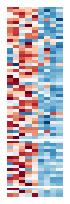

In [30]:
key = 'cb6f1_kupffer_trans_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(z_frame_c57.loc[geneset, :],
                cmap='RdBu_r',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=-2,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

## Balb

### Log 2 Expression

In [ ]:
key = 'cb6f1_kupffer_trans_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(np.log2(tpm_mat_balb.loc[geneset, :]+1),
                cmap='Blues',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=10,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

### Z Score

35
23
5


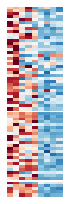

In [32]:
key = 'cb6f1_kupffer_trans_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(z_frame_balb.loc[geneset, :],
                cmap='RdBu_r',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=-2,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'horizontal',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
#             bbox_inches='tight')

# Mixed
## C57
### Log2Expression

2
30
6


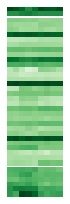

In [35]:
key = 'cb6f1_kupffer_mixed_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(np.log2(tpm_mat_c57.loc[geneset, :]+1),
                cmap='Greens',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=10,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

### Z Score

2
30
6


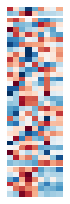

In [36]:
key = 'cb6f1_kupffer_mixed_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(z_frame_c57.loc[geneset, :],
                cmap='RdBu_r',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=-2,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

## BALB
# Log 2 Expression

3
48
9


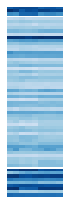

In [41]:
key = 'cb6f1_kupffer_mixed_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(np.log2(tpm_mat_balb.loc[geneset, :]+1),
                cmap='Blues',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=10,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

### Z Score

3
48
9


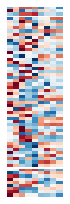

In [40]:
key = 'cb6f1_kupffer_mixed_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(z_frame_balb.loc[geneset, :],
                cmap='RdBu_r',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=-2,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'horizontal',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
#             bbox_inches='tight')

# Cis
## C57
### Log2Expression

36
3
14


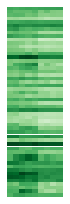

In [39]:
key = 'cb6f1_kupffer_cis_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(np.log2(tpm_mat_c57.loc[geneset, :]+1),
                cmap='Greens',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=10,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

### Z Score

36
3
14


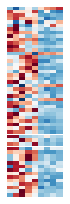

In [38]:
key = 'cb6f1_kupffer_cis_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(z_frame_c57.loc[geneset, :],
                cmap='RdBu_r',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=-2,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

## BALB
### Log2Expression

27
5
23


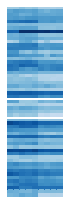

In [46]:
key = 'cb6f1_kupffer_cis_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(np.log2(tpm_mat_balb.loc[geneset, :]+1),
                cmap='Blues',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=10,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

### Z Score

27
5
23


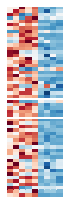

In [44]:
key = 'cb6f1_kupffer_cis_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(z_frame_balb.loc[geneset, :],
                cmap='RdBu_r',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=-2,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

# plt.savefig('./figures/'+key+'_heatmap_custom_order.ptpm_mat',
#             bbox_inches='tight')

# Make colorbars

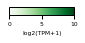

In [50]:
fig, ax = plt.subplots(figsize=(2,1))

cmap = matplotlib.cm.Greens
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
plt.gca().set_visible(False)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  use_gridspec=True,
                  orientation='horizontal',
                  label='log2(TPM+1)',
                  aspect=8)
plt.savefig('./expression_heatmaps/c57bl6j_tpm_colorbar.pdf',
            bbox_inches='tight')

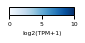

In [51]:
fig, ax = plt.subplots(figsize=(2,1))

cmap = matplotlib.cm.Blues
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
plt.gca().set_visible(False)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  use_gridspec=True,
                  orientation='horizontal',
                  label='log2(TPM+1)',
                  aspect=8)
plt.savefig('./expression_heatmaps/balbcj_tpm_colorbar.pdf',
            bbox_inches='tight')

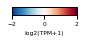

In [52]:
fig, ax = plt.subplots(figsize=(2,1))

cmap = matplotlib.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-2, vmax=2)
plt.gca().set_visible(False)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  use_gridspec=True,
                  orientation='horizontal',
                  label='log2(TPM+1)',
                  aspect=8)
plt.savefig('./expression_heatmaps/z_scale_colorbar.pdf',
            bbox_inches='tight')